<a href="https://colab.research.google.com/github/neko2048/git-example/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import kaggle's titanic dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"neko1024","key":"8bc748ae8e77fd50b11b512b21ee132f"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 64 Jul 26 04:34 kaggle.json
{"username":"neko1024","key":"8bc748ae8e77fd50b11b512b21ee132f"}

In [0]:
#install kaggle package
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 5.3MB 9.1MB/s 
     |████████████████████████████████| 102kB 33.5MB/s 
     |████████████████████████████████| 112kB 55.6MB/s 
     |████████████████████████████████| 51kB 25.0MB/s 


In [0]:
#import datasets in kaggle
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 22.7MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.18MB/s]


In [0]:
!ls

gender_submission.csv  kaggle.json  sample_data  test.csv  train.csv


In [0]:
#load package
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale = 1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

#load data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_data = df_train.append(df_test) #combine two into one

#for displaying dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
  html_str = ""
  for df in args:
    html_str += df.to_html()
  display_html(html_str.replace('table', 'tabel style = "display:inline"'), raw = True)

#ignore warning
#!pip install warning
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Sex,Survived
0,female,0.742
1,male,0.189


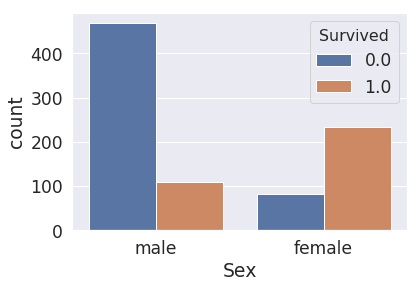

In [0]:
#M/F survived rate
sns.countplot(df_data["Sex"], hue = df_data["Survived"])
display(df_data[["Sex", "Survived"]].groupby(["Sex"], as_index = False).mean().round(3))

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


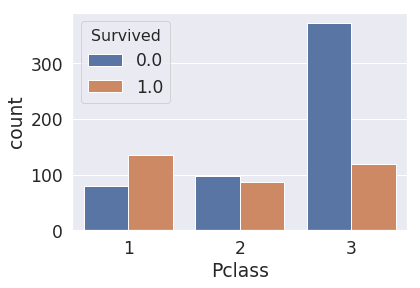

In [0]:
#Pclass survived rate
sns.countplot(df_data["Pclass"], hue = df_data["Survived"])
display(df_data[["Pclass", "Survived"]].groupby(["Pclass"], as_index = False).mean().round(3))

In [0]:
#convert sex to 0/1
df_data["Sex_code"] = df_data["Sex"].map({'female' : 1, 'male' : 0}).astype("int")

In [0]:
#split data into train and test
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

#inputs set and label
x = df_train.drop(labels = ["Survived", "PassengerId"], axis = 1)
y = df_train["Survived"]

In [0]:
#show baseline
Base = ["Sex_code", "Pclass"]
Base_Model = RandomForestClassifier(random_state = 2, n_estimators = 250, 
                                    min_samples_split = 20, oob_score = True)
Base_Model.fit(x[Base], y)
print("Base oob score : %.5f" %(Base_Model.oob_score))

Base oob score : 1.00000


In [0]:
predict = Base_Model.predict(df_test[Base])
submit_1 = pd.DataFrame({"Survived" : predict})

In [0]:
submit_1.to_csv("submit_1.csv", encoding='utf-8', index=False)

In [0]:
def transform_to_cvs(predict_array):
  submission = pd.DataFrame({"PassengerId" : [x for x in range(892, 1310)],
                             "Survived" : predict_array})
  submission.to_csv("submission.csv", encoding = 'utf-8', index = False)
  

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

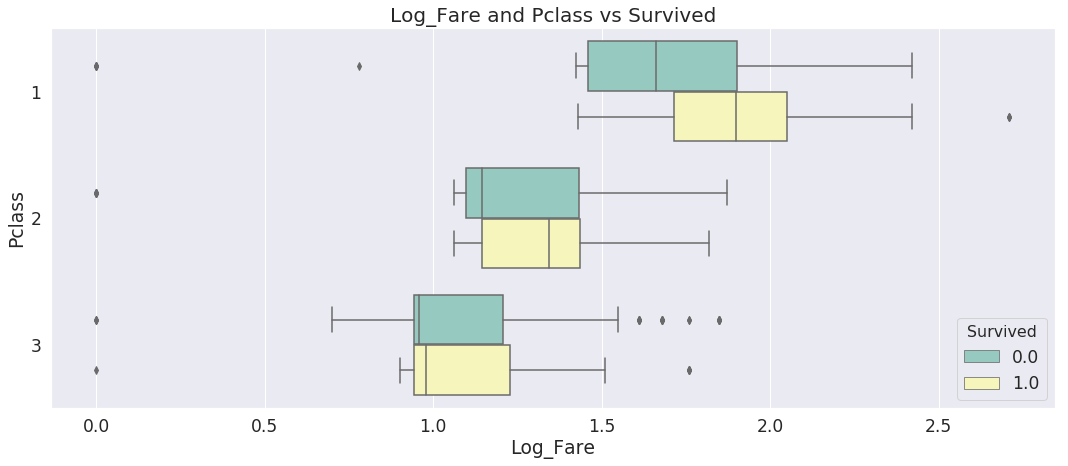

In [0]:
#fare
fig, ax = plt.subplots(figsize = (18, 7))
df_data["Log_Fare"] = (df_data["Fare"] + 1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y = "Pclass", x = "Log_Fare", hue = "Survived", data = df_data, orient = 'h',
           ax = ax, palette = "Set3")
ax.set_title("Log_Fare and Pclass vs Survived", fontsize = 20)
pd.pivot_table(df_data, values = ["Fare"], index = ["Pclass"], columns = ["Survived"], 
              aggfunc = 'median').round(3)

In [0]:
#fill missing data
df_data["Fare"] = df_data["Fare"].fillna(df_data["Fare"].median())

In [0]:
#make bins
df_data["FareBin_4"] = pd.qcut(df_data["Fare"], 4)
df_data["FareBin_5"] = pd.qcut(df_data["Fare"], 5)
df_data["FareBin_6"] = pd.qcut(df_data["Fare"], 6)

label = LabelEncoder()
df_data["FareBin_Code_4"] = label.fit_transform(df_data["FareBin_4"])
df_data["FareBin_Code_5"] = label.fit_transform(df_data["FareBin_5"])
df_data["FareBin_Code_6"] = label.fit_transform(df_data["FareBin_6"])

In [0]:
#cross tab
df_4 = pd.crosstab(df_data["FareBin_Code_4"], df_data["Pclass"])
df_5 = pd.crosstab(df_data["FareBin_Code_5"], df_data["Pclass"])
df_6 = pd.crosstab(df_data["FareBin_Code_6"], df_data["Pclass"])

display_side_by_side(df_4, df_5, df_6)

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


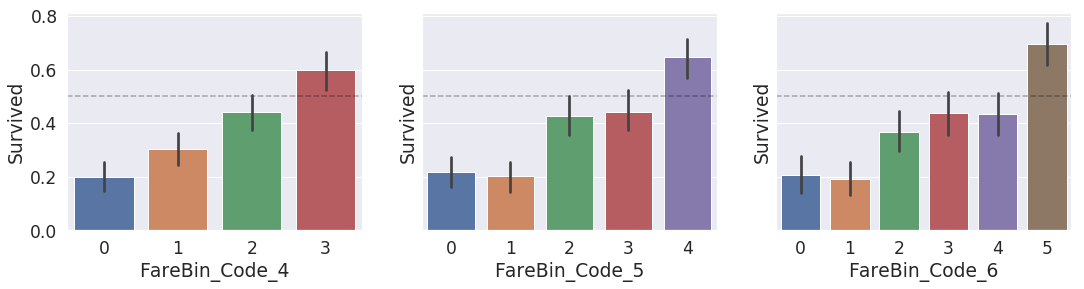

In [0]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey = True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
  axi.axhline(0.5, linestyle = "dashed", c = "black", alpha = 0.3)
g1 = sns.factorplot(x = "FareBin_Code_4", y = "Survived", data = df_data, kind = "bar", ax = ax1)
g2 = sns.factorplot(x = "FareBin_Code_5", y = "Survived", data = df_data, kind = "bar", ax = ax2)
g3 = sns.factorplot(x = "FareBin_Code_6", y = "Survived", data = df_data, kind = "bar", ax = ax3)
#close facegrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

In [0]:
#split again
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
#train set and label
x = df_train.drop(labels = ["Survived", "PassengerId"], axis = 1)
y = df_train["Survived"]
print(x.columns)

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')


In [0]:
compare = ["Sex_code", "Pclass", "FareBin_Code_4", "FareBin_Code_5", "FareBin_Code_6"]
selector = RFECV(RandomForestClassifier(n_estimators=250, min_samples_split=20), cv = 10, n_jobs = -1)
selector.fit(x[compare], y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_ * 100)

[ True  True  True  True  True]
[1 1 1 1 1]
[78.66981614 77.33398593 79.35274089 79.68990466 80.36655885]


In [0]:
score_b4, score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
  diff_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
  selector = RFECV(RandomForestClassifier(random_state = i, n_estimators=250, 
                                          min_samples_split=20), cv = diff_cv, n_jobs = -1)
  selector.fit(x[compare], y)
  score_b4.append(selector.grid_scores_[2])
  score_b5.append(selector.grid_scores_[3])
  score_b6.append(selector.grid_scores_[4])

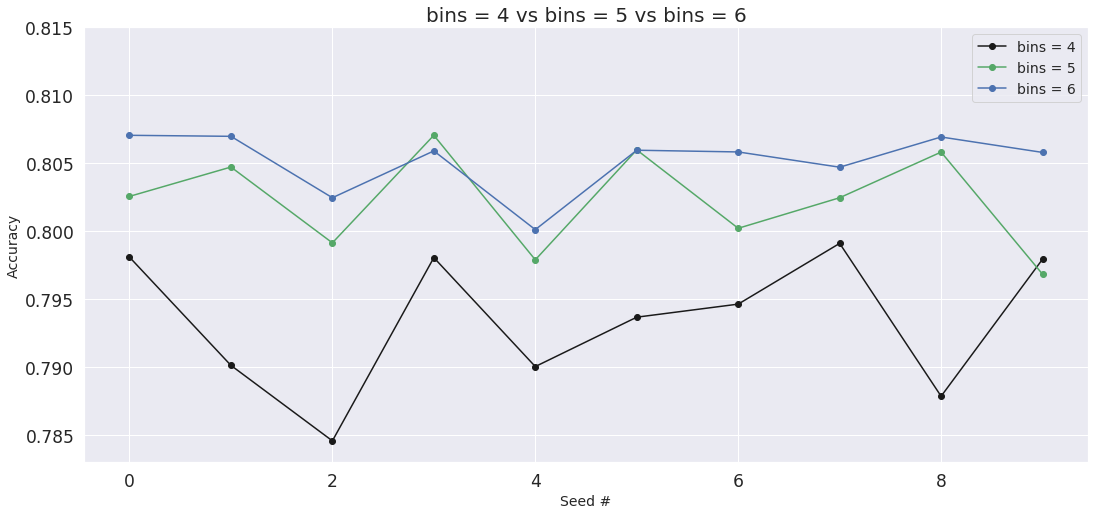

In [0]:
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
  item = np.array(item * 100)
#plot
fig = plt.figure(figsize = (18, 8))
ax = plt.gca()
ax.plot(range(seeds), score_b4, '-ok', label = 'bins = 4')
ax.plot(range(seeds), score_b5, '-og', label = 'bins = 5')
ax.plot(range(seeds), score_b6, '-ob', label = 'bins = 6')
ax.set_xlabel("Seed #", fontsize = '14')
ax.set_ylim(0.783, 0.815)
ax.set_ylabel("Accuracy", fontsize = '14')
ax.set_title("bins = 4 vs bins = 5 vs bins = 6", fontsize = '20')
plt.legend(fontsize = '14', loc = 'upper right')

In [0]:
b5 = ["Sex_code", "Pclass", "FareBin_Code_5"]
b5_Model = RandomForestClassifier(random_state=2, n_estimators=250, 
                                  min_samples_split=20, oob_score = True)
b5_Model.fit(x[b5], y)
print(b5_Model.oob_score_)

0.8103254769921436


In [0]:
transform_to_cvs(b5_Model.predict(df_test[b5]))

In [0]:
df_train["Ticket"].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [0]:
#family size
df_data["Family_size"] = df_data["SibSp"] + df_data["Parch"] + 1

In [0]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
  tem = df_data.loc[df_data.Ticket == tk, 'Fare']
  if tem.count() > 1:
    deplicate_ticket.append(df_data.loc[df_data.Ticket == tk, ["Name", "Ticket", "Fare", 
                                                             "Cabin", "Family_size", "Survived"]])
deplicate_ticket = pd.concat(deplicate_ticket)
print(deplicate_ticket.head(14))

                                                  Name  ... Survived
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  ...      1.0
234                          Cumings, Mr. John Bradley  ...      NaN
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  ...      1.0
137                        Futrelle, Mr. Jacques Heath  ...      0.0
6                              McCarthy, Mr. Timothy J  ...      0.0
146                        Hilliard, Mr. Herbert Henry  ...      NaN
7                       Palsson, Master. Gosta Leonard  ...      0.0
24                       Palsson, Miss. Torborg Danira  ...      0.0
374                         Palsson, Miss. Stina Viola  ...      0.0
567        Palsson, Mrs. Nils (Alma Cornelia Berglund)  ...      0.0
389                        Palsson, Master. Paul Folke  ...      NaN
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  ...      1.0
172                       Johnson, Miss. Eleanor Ileen  ...      1.0
869                    Johnson, Ma

In [0]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri, df_fami)
print('people keep the same ticket: %.0f' % len(deplicate_ticket))
print('friends: %.0f'%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f'%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))


,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596
friends: 127
families: 469


In [0]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
  tem = df_data.loc[df_data.Ticket == tk, "Fare"]
  if tem.count() > 1:
    deplicate_ticket.append(df_data.loc[df_data.Ticket == tk, ["Name", "Ticket", "Fare", "Cabin", 
                                                  "Family_size", "Survived"]])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [0]:
df_data['Connected_Survival'] = 0.5
for _, df_grp in df_data.groupby('Ticket'):
  if (len(df_grp) > 1):
    for ind, row in df_grp.iterrows():
      smax = df_grp.drop(ind)["Survived"].max()
      smin = df_grp.drop(ind)["Survived"].min()
      passID = row["PassengerId"]
      if (smax == 1.0):
        df_data.loc[df_data["PassengerId"] == passID, "Connected_Survival"] = 1
      elif (smin == 0.0):
        df_data.loc[df_data["PassengerId"] == passID, "Connected_Survival"] = 0
print("People keep same ticket: %.0f" %len(deplicate_ticket))
print("People have connected information: %.0f"
     %(df_data[df_data["Connected_Survival"] != 0.5].shape[0]))
df_data.groupby("Connected_Survival")[["Survived"]].mean().round(3)

People keep same ticket: 596
People have connected information: 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [0]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

x = df_train.drop(labels = ["Survived", "PassengerId"], axis = 1)
y = df_train["Survived"]

In [0]:
connect = ["Sex_code", "Pclass", "FareBin_Code_5", "Connected_Survival"]
connect_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, 
                                      oob_score = True)
connect_Model.fit(x[connect], y)
print("Connect oob score: %.5f" %(connect_Model.oob_score_))

Connect oob score: 0.82043


In [0]:
transform_to_cvs(connect_Model.predict(df_test[connect]))

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


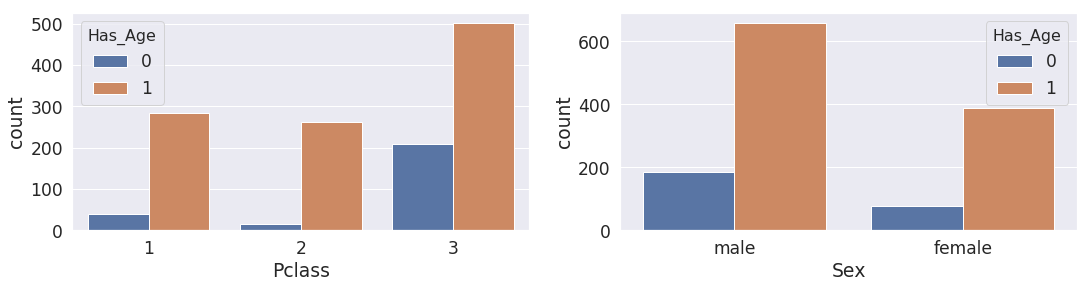

In [0]:
df_data["Has_Age"] = df_data["Age"].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data["Pclass"], hue = df_data["Has_Age"], ax = ax1)
ax2 = sns.countplot(df_data["Sex"], hue = df_data["Has_Age"], ax = ax2)
pd.crosstab(df_data["Has_Age"], df_data["Sex"], margins = True).round(3)

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1, 2')

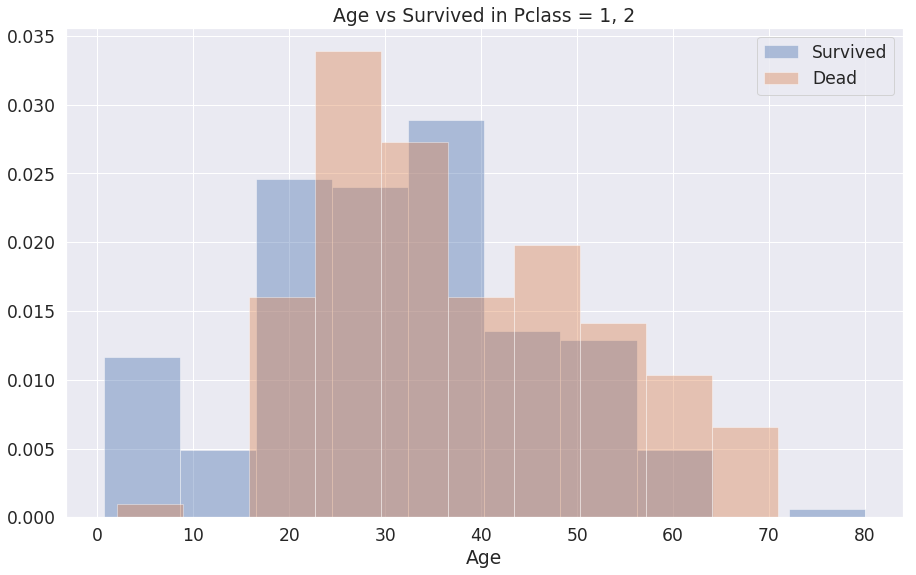

In [0]:
Mask_Has_Age_P12_Survived = ((df_data.Has_Age == 1) & (df_data.Pclass != 3) & (df_data.Survived == 1))
Mask_Has_Age_P12_Dead = ((df_data.Has_Age == 1) & (df_data.Pclass != 3) & (df_data.Survived == 0))

fig, ax = plt.subplots(figsize = (15, 9))
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, "Age"], kde = False, bins = 10,
                 norm_hist = True, label = "Survived")
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, "Age"], kde = False, bins = 10, 
                 norm_hist = True, label = "Dead")
ax.legend()
ax.set_title("Age vs Survived in Pclass = 1, 2")

In [0]:
df_data["Title"] = df_data.Name.str.extract(" ([A-Za-z]+)\.", expand = False)
df_data["Title"] = df_data["Title"].replace(["Capt", "Col", "Countess", "Don", 
                                             "Dr", "Dona", "Jonkheer", 
                                            "Major", "Rev", "Sir"], "Rare")
df_data["Title"] = df_data["Title"].replace(["Mlle", "Ms", "Mme"], "Miss")
df_data["Title"] = df_data["Title"].replace(["Lady"], "Mrs")
df_data["Title"] = df_data["Title"].map({"Mr":0, "Rare":1, "Master":2, "Miss":3, "Mrs":4})
Ti = df_data.groupby("Title")["Age"].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [0]:
Ti_pred = df_data.groupby("Title")["Age"].median().values
df_data["Ti_Age"] = df_data["Age"]

for i in range(0, 5):
  df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i), "Ti_Age"] = Ti_pred[i]
df_data["Ti_Age"] = df_data["Ti_Age"].astype("int")
df_data["Ti_Minor"] = ((df_data["Ti_Age"]) < 16.0) * 1

In [0]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

x = df_train.drop(labels = ["Survived", "PassengerId"], axis = 1)
y = df_train["Survived"]

In [0]:
minor = ["Sex_code", "Pclass", "FareBin_Code_5", "Connected_Survival", "Ti_Minor"]
minor_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, 
                                    oob_score = True)
minor_Model.fit(x[minor], y)
print("oob_score: %.0f" %(minor_Model.oob_score_))

oob_score: 1


In [0]:
transform_to_cvs(minor_Model.predict(df_test[minor]))